## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression

In [1]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape
 
X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

- We do not normalize the miRNA expression values because we are using Read Per Kilobase Million Mapped

In [14]:
X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]
X_I_vs_II = X[X['pathologic_stage'].isin(['Stage I', 'Stage II'])]
X_II_vs_III = X[X['pathologic_stage'].isin(['Stage II', 'Stage III'])]
X_III_vs_IV = X[X['pathologic_stage'].isin(['Stage III', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']
Y_I_vs_II = X_I_vs_II['pathologic_stage']
Y_II_vs_III = X_II_vs_III['pathologic_stage']
Y_III_vs_IV = X_III_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')
X_I_vs_II.__delitem__('patient_barcode')
X_I_vs_II.__delitem__('pathologic_stage')
X_II_vs_III.__delitem__('patient_barcode')
X_II_vs_III.__delitem__('pathologic_stage')
X_III_vs_IV.__delitem__('patient_barcode')
X_III_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


## Hyper-parameter selection for elastic net

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from matplotlib import pyplot as plt

parameters = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [1.0, 0.75, 0.5, 0.25, 0.1, 0.01],
    'l1_ratio': [0.0, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95, 1.0],
    'n_iter': [5, 50, 100, 200],
    'fit_intercept': [False]
}


# cv = model_selection.StratifiedKFold(Y_normal_vs_IV, 2)

grid_search = model_selection.GridSearchCV(SGDClassifier(), parameters, cv=5, n_jobs=4)
grid_search.fit(X, Y)

print "Best %s: %0.3f" % (score_func.__name__, grid_search.best_score_)
print "Best parameters set:"
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print "\t%s: %r" % (param_name, best_parameters[param_name])

print
print "CROSS VALIDATION:"
clf = SGDClassifier(**best_parameters)
scores = model_selection.cross_val_score(clf, X, Y)
print 'Best %s: %0.3f (+/- %0.2f)' % \
    (score_func.__name__, scores.mean(), scores.std() / 2)
#
# cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 1)
# model = linear_model.LogisticRegression(C=0.1, penalty='l1', fit_intercept=False)
# coefs_ = []
# for c in cs:
#     model.set_params(C=c)
#     model.fit(X, Y)
#     coefs_.append(model.coef_.ravel().copy())
#
# coefs_ = np.array(coefs_)
# plt.plot(cs, coefs_)
# ymin, ymax = plt.ylim()
# plt.xlabel('C')
# plt.ylabel('Coefficients')
# plt.title('Logistic Regression Path')
# plt.axis('tight')
# plt.show()

In [17]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

print Y_normal_vs_I.value_counts()
print Y_normal_vs_II.value_counts()
print Y_normal_vs_III.value_counts()
print Y_normal_vs_IV.value_counts()

mirna_list 1881
validated_miRNAs 27
number of validated miRNAs in list of all miRNAs 21
Stage I    277
normal      46
Name: pathologic_stage, dtype: int64
Stage II    121
normal       46
Name: pathologic_stage, dtype: int64
Stage III    84
normal       46
Name: pathologic_stage, dtype: int64
normal      46
Stage IV    24
Name: pathologic_stage, dtype: int64


## Split train and test data for X normal vs I, normal vs II, normal vs III and normal vs IV

In [77]:
from sklearn.model_selection import train_test_split

X_normal_vs_I_train, X_normal_vs_I_test, Y_normal_vs_I_train, Y_normal_vs_I_test = \
    train_test_split(X_normal_vs_I, Y_normal_vs_I, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_II_train, X_normal_vs_II_test, Y_normal_vs_II_train, Y_normal_vs_II_test = \
    train_test_split(X_normal_vs_II, Y_normal_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_III_train, X_normal_vs_III_test, Y_normal_vs_III_train, Y_normal_vs_III_test = \
    train_test_split(X_normal_vs_III, Y_normal_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_IV_train, X_normal_vs_IV_test, Y_normal_vs_IV_train, Y_normal_vs_IV_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


X_I_vs_II_train, X_I_vs_II_test, Y_I_vs_II_train, Y_I_vs_II_test = \
    train_test_split(X_I_vs_II, Y_I_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_II_vs_III_train, X_II_vs_III_test, Y_II_vs_III_train, Y_II_vs_III_test = \
    train_test_split(X_II_vs_III, Y_II_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_III_vs_IV_train, X_III_vs_IV_test, Y_III_vs_IV_train, Y_III_vs_IV_test = \
    train_test_split(X_III_vs_IV, Y_III_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))

## Perform classification for normal vs Stage I, Stage II, Stage III, and Stage IV 
### SGDClassifier is a linear classifier (SVM, elasticnet) that uses schochastic gradient descend


In [92]:
from sklearn import linear_model
from sklearn import metrics
import numpy as np

normal_vs_I =   linear_model.SGDClassifier(**best_parameters)
normal_vs_II =  linear_model.SGDClassifier(**best_parameters)
normal_vs_III = linear_model.SGDClassifier(**best_parameters)
normal_vs_IV =  linear_model.SGDClassifier(**best_parameters)

I_vs_II =  linear_model.SGDClassifier(**best_parameters)
II_vs_III =  linear_model.SGDClassifier(**best_parameters)
III_vs_IV =  linear_model.SGDClassifier(**best_parameters)

print normal_vs_I.fit(X_normal_vs_I_train, Y_normal_vs_I_train)
print normal_vs_II.fit(X_normal_vs_II_train, Y_normal_vs_II_train)
print normal_vs_III.fit(X_normal_vs_III_train, Y_normal_vs_III_train)
print normal_vs_IV.fit(X_normal_vs_IV_train, Y_normal_vs_IV_train)
print I_vs_II.fit(X_I_vs_II_train, Y_I_vs_II_train)
print II_vs_III.fit(X_II_vs_III_train, Y_II_vs_III_train)
print III_vs_IV.fit(X_III_vs_IV_train, Y_III_vs_IV_train)


# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


## Show number of candidate miRNAs, top miRNA's based on coefficient, and percentage of known miRNA

In [93]:
from src.utils.validate_candidate_miRNAs import percent_candidate_in_validated
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV, I_vs_II, II_vs_III,
                        III_vs_IV],
                       ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV', 'I_vs_II',
                        'II_vs_III', 'III_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})

    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    
    print "Percentage of known miRNAs:", percent_candidate_in_validated(df['mirna'].tolist(), validated_miRNAs)
    print set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    
    results.append(df)


normal_vs_I
Non-zero coef: 104
     coefficient         mirna
75     13.460281   hsa-mir-30a
1       9.193445  hsa-let-7a-2
10      8.062570   hsa-mir-100
103     6.721471   hsa-mir-99b
8       6.573172  hsa-let-7f-2
7       6.512798  hsa-let-7f-1
    coefficient         mirna
31   -30.490312  hsa-mir-148a
57   -30.024510    hsa-mir-22
38   -20.560894   hsa-mir-182
52   -18.342292  hsa-mir-203a
85   -15.890498   hsa-mir-375
42   -13.710375   hsa-mir-192
Percentage of known miRNAs: 0.37037037037
set(['hsa-mir-200b', 'hsa-mir-200c', 'hsa-mir-200a', 'hsa-mir-99a', 'hsa-mir-374a', 'hsa-mir-429', 'hsa-mir-150', 'hsa-mir-145', 'hsa-mir-141', 'hsa-mir-30a']) 10

normal_vs_II
Non-zero coef: 93
    coefficient         mirna
9     18.934122   hsa-mir-100
25    16.713771   hsa-mir-143
2     12.502808  hsa-let-7a-3
0     12.431059  hsa-let-7a-1
92    10.808290   hsa-mir-99b
1     10.246445  hsa-let-7a-2
    coefficient         mirna
29   -35.834044  hsa-mir-148a
54   -26.755187    hsa-mir-22
15  

## Count number of miRNAs mutually selected between the classifiers

In [53]:
for i in range(len(results)):
    for j in range(len(results)):
        print '\n', "Stage "+str(i+1)+' - Stage '+str(j+1), ' : ',len(set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist()))
        # print set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist())


Stage 1 - Stage 1  :  254

Stage 1 - Stage 2  :  182

Stage 1 - Stage 3  :  185

Stage 1 - Stage 4  :  216

Stage 1 - Stage 5  :  163

Stage 1 - Stage 6  :  190

Stage 1 - Stage 7  :  174

Stage 2 - Stage 1  :  182

Stage 2 - Stage 2  :  202

Stage 2 - Stage 3  :  180

Stage 2 - Stage 4  :  188

Stage 2 - Stage 5  :  159

Stage 2 - Stage 6  :  181

Stage 2 - Stage 7  :  169

Stage 3 - Stage 1  :  185

Stage 3 - Stage 2  :  180

Stage 3 - Stage 3  :  232

Stage 3 - Stage 4  :  204

Stage 3 - Stage 5  :  163

Stage 3 - Stage 6  :  191

Stage 3 - Stage 7  :  175

Stage 4 - Stage 1  :  216

Stage 4 - Stage 2  :  188

Stage 4 - Stage 3  :  204

Stage 4 - Stage 4  :  281

Stage 4 - Stage 5  :  180

Stage 4 - Stage 6  :  200

Stage 4 - Stage 7  :  190

Stage 5 - Stage 1  :  163

Stage 5 - Stage 2  :  159

Stage 5 - Stage 3  :  163

Stage 5 - Stage 4  :  180

Stage 5 - Stage 5  :  205

Stage 5 - Stage 6  :  175

Stage 5 - Stage 7  :  168

Stage 6 - Stage 1  :  190

Stage 6 - Stage 2  :  181



## Classification results

In [94]:
print metrics.classification_report(Y_normal_vs_I_test, normal_vs_I.predict(X_normal_vs_I_test),
                                    labels=['normal', 'Stage I'], 
                                    target_names=['normal', 'Stage I']) 
print metrics.classification_report(Y_normal_vs_II_test, normal_vs_II.predict(X_normal_vs_II_test), 
                                    labels=['normal', 'Stage II'], 
                                    target_names=['normal', 'Stage II']) 
print metrics.classification_report(Y_normal_vs_III_test, normal_vs_III.predict(X_normal_vs_III_test), 
                                    labels=['normal', 'Stage III'], 
                                    target_names=['normal', 'Stage III']) 
print metrics.classification_report(Y_normal_vs_IV_test, normal_vs_IV.predict(X_normal_vs_IV_test), 
                                    labels=['normal', 'Stage IV'], 
                                    target_names=['normal', 'Stage IV'])
print metrics.classification_report(Y_I_vs_II_test, I_vs_II.predict(X_I_vs_II_test), 
                                    labels=['Stage I', 'Stage II'], 
                                    target_names=['Stage I', 'Stage II'])
print metrics.classification_report(Y_II_vs_III_test, II_vs_III.predict(X_II_vs_III_test), 
                                    labels=['Stage II', 'Stage III'], 
                                    target_names=['Stage II', 'Stage III'])
print metrics.classification_report(Y_III_vs_IV_test, III_vs_IV.predict(X_III_vs_IV_test), 
                                    labels=['Stage III', 'Stage IV'], 
                                    target_names=['Stage III', 'Stage IV'])

             precision    recall  f1-score   support

     normal       0.86      0.75      0.80         8
    Stage I       0.97      0.98      0.97        57

avg / total       0.95      0.95      0.95        65

             precision    recall  f1-score   support

     normal       0.80      1.00      0.89         8
   Stage II       1.00      0.92      0.96        26

avg / total       0.95      0.94      0.94        34

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         7
  Stage III       1.00      1.00      1.00        19

avg / total       1.00      1.00      1.00        26

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00        10
   Stage IV       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        14

             precision    recall  f1-score   support

    Stage I       0.61      0.98      0.75        49
   Stage II       0.00      0.00 

## Plot manhattan plot of selected miRNAs by the classifiers

139


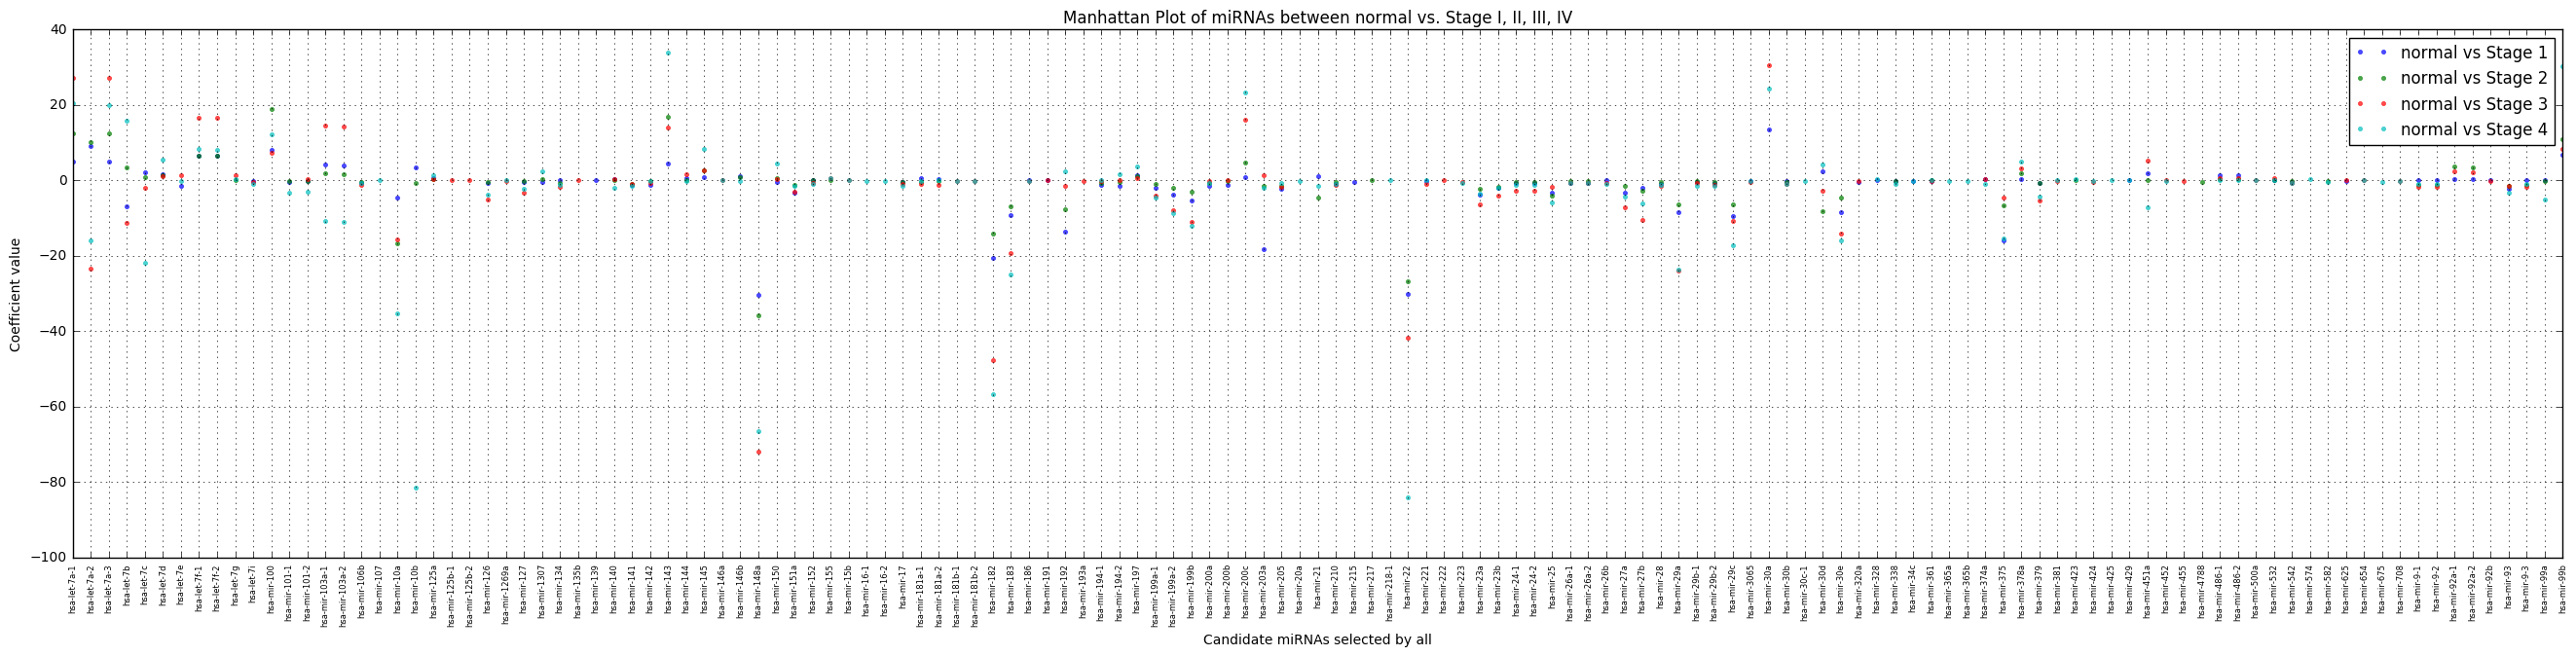

In [95]:
from matplotlib import pyplot as plt

all_candidate_miRNAs = set(results[0]['mirna']) | set(results[1]['mirna']) | set(results[2]['mirna']) | \
                       set(results[3]['mirna'])
sorted_candidate_miRNAs = []
for miR in mirna_list:
    if miR in all_candidate_miRNAs:
        sorted_candidate_miRNAs.append(miR)
print sorted_candidate_miRNAs.__len__()

plt.figure(figsize=(33, 7))
plt.xticks(range(sorted_candidate_miRNAs.__len__()), sorted_candidate_miRNAs, rotation='vertical', fontsize=6)

for i in [0,1,2,3]:
    x_indx = []
    y_values = []
    for x_str in results[i]['mirna']:
        # print all_candidate_miRNAs.index(x_str)
        x_indx.append(sorted_candidate_miRNAs.index(x_str))

    for y_value in results[i]['coefficient']:
        y_values.append(y_value)


    plt.plot(x_indx, y_values, marker='.', linestyle='', alpha=0.7, label='normal vs Stage '+str(i+1))

plt.legend()
plt.ylabel('Coefficient value')
plt.xlabel('Candidate miRNAs selected by all')
plt.title('Manhattan Plot of miRNAs between normal vs. Stage I, II, III, IV')
plt.axis('auto')
plt.grid(True)
plt.show()